The aim is to predict soil organic carbon off of variables: annual temperature, annual precipitation, tillage, cover crop group, grain crop group, and conservation type

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

# some models to try
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#plotting and result analysis
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [23]:
data = pd.read_csv('./data/soc_dataset.csv')
data.head(10)

,Country,Tannual,Pannual,OC,Tillage,CoverCropGroup,GrainCropGroup,Conservation_Type,Type
0,USA,19.6,976.0,0.74,Reduced,Legume,Monoculture,CC,_T
1,USA,19.6,976.0,0.70,Reduced,Legume,Monoculture,CC,_T
2,USA,19.6,976.0,0.59,Reduced,Legume,Monoculture,CC,_T
3,USA,19.6,976.0,0.73,Reduced,Legume,Monoculture,CC,_T
4,USA,19.6,976.0,0.74,Reduced,Legume,Monoculture,CC,_T
5,USA,19.6,976.0,0.54,Reduced,Legume,Monoculture,CC,_T
6,USA,19.6,976.0,0.70,Reduced,Legume,Monoculture,CC,_T
7,USA,19.6,976.0,0.73,Reduced,Legume,Monoculture,CC,_T
8,USA,19.6,976.0,0.52,Reduced,Legume,Monoculture,CC,_T
9,USA,15.7,1352.0,2.20,No,Rye,Monoculture,CC-NT,_T


In [24]:
print("Unique values in 'Tillage':", data['Tillage'].unique())
print("Unique values in 'CoverCropGroup':", data['CoverCropGroup'].unique())
print("Unique values in 'GrainCropGroup':", data['GrainCropGroup'].unique())

Unique values in 'Tillage': ['Reduced' 'No' 'Unknown' 'Conventional']
Unique values in 'CoverCropGroup': ['Legume' 'Rye' 'Grass' 'Brassica' 'Mixed' 'Unknown' 'No']
Unique values in 'GrainCropGroup': ['Monoculture' 'Monoculture-rotation' 'Vegetable' 'Unknown']


Numeric fields need to be scaled, and non-numeric need to be split (onehotencoder)

In [25]:
# Identify numeric and categorical columns
numeric_features = ['Tannual', 'Pannual']
categorical_features = ['Tillage', 'CoverCropGroup', 'GrainCropGroup'] # , 'Conservation_Type'

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', dtype='int32'))
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('normalizer', Normalizer())
])

preprocessor = ColumnTransformer([
    ('categoricals', categorical_transformer, categorical_features),
    ('numericals', numeric_transformer, numeric_features)
])

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)) #RandomForestClassifier(n_estimators=10)) #tree.DecisionTreeClassifier()) #LinearRegression() 
    ]
)

In [ ]:
# Features and target
X = data[numeric_features+ categorical_features] 
y = data['OC']

# split: train and test (15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)


In [ ]:


# Define models and parameter grids
models_params = {
    'RandomForestRegressor': {
        'clf': [RandomForestRegressor(random_state=42)],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [None, 5, 10]
    },
    'LinearRegression': {
        'clf': [LinearRegression()]
    },
    'Ridge': {
        'clf': [Ridge(alpha=1.0)],
        'clf__alpha': [0.1, 1.0, 10.0]
    }
}

best_score = -float('inf')
best_model = None
best_params = None

for name, params in models_params.items():
    search = GridSearchCV(pipeline, params, cv=KFold(n_splits=5, shuffle=True, random_state=1), scoring='r2', n_jobs=-1)
    search.fit(X_train, y_train)
    print(f"{name} best CV R^2: {search.best_score_:.3f}")
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_params = search.best_params_

print("Best model:", best_model)
print("Best parameters:", best_params)

RandomForestRegressor best CV R^2: 0.760
LinearRegression best CV R^2: 0.423
Ridge best CV R^2: 0.424
Best model: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(dtype='int32',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Tillage', 'CoverCropGroup',
                                                   'GrainCropGroup']),
                                                 ('numericals',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('normalizer',
                                            

The highest R^2 is for RandomForestRegressor, so it will be used for the final predictions. 

In [50]:
best_model.fit(X_train, y_train, groups=X_train)

ValueError: Pipeline.fit does not accept the groups parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

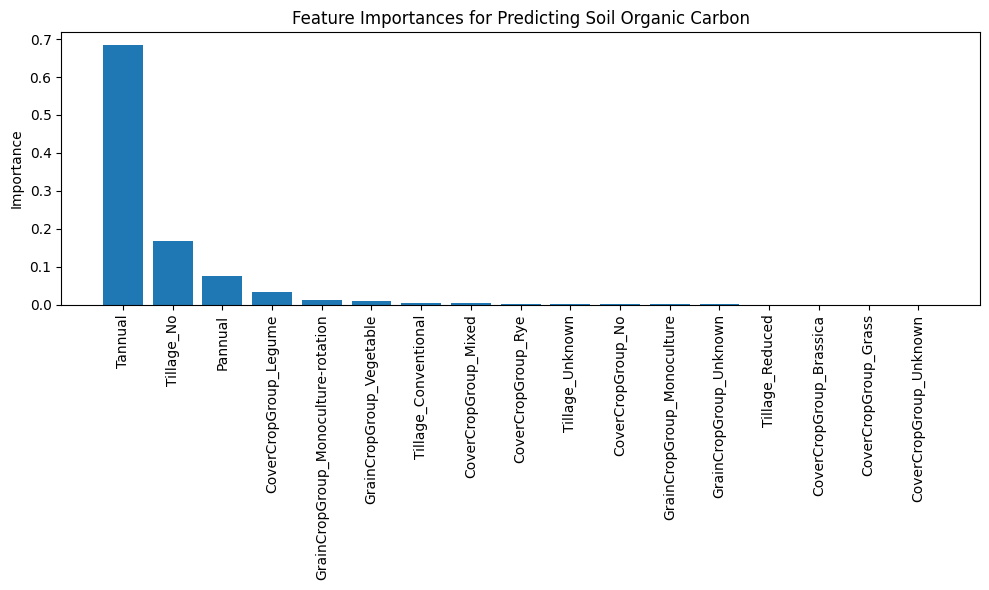

In [48]:
# Get feature importances from the trained RandomForestRegressor
importances = best_model.named_steps['clf'].feature_importances_

# Get feature names from the preprocessor
cat_names = best_model.named_steps['preprocessing'].named_transformers_['categoricals'].named_steps['onehot'].get_feature_names_out(categorical_features)
num_names = numeric_features
feature_names = list(cat_names) + num_names

# Plot feature importances
plt.figure(figsize=(10, 6))
sorted_idx = importances.argsort()[::-1]
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.title('Feature Importances for Predicting Soil Organic Carbon')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

The top variables are annual temperature, no tillage, and annual precipitation. The two environmental variables cannot be changed at a farm, though irrigation can occur, but if not tilling has a positive effect the user can reduce or eliminate tilling on their land to help improve organic carbon in the soil.

Predicting validation set

In [34]:
y_pred_val = best_model.predict(X_val)

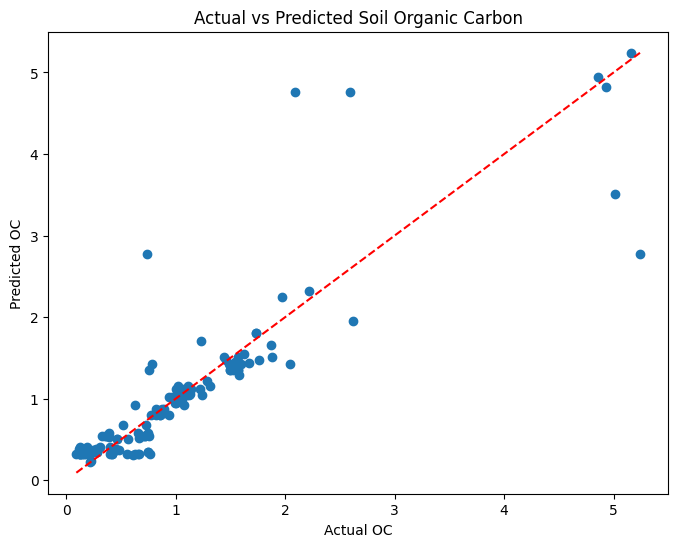

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_val)
plt.xlabel('Actual OC')
plt.ylabel('Predicted OC')
plt.title('Actual vs Predicted Soil Organic Carbon')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

Predictions for Random Forest Regression

In [12]:
y_pred=pipeline.predict(X_test)

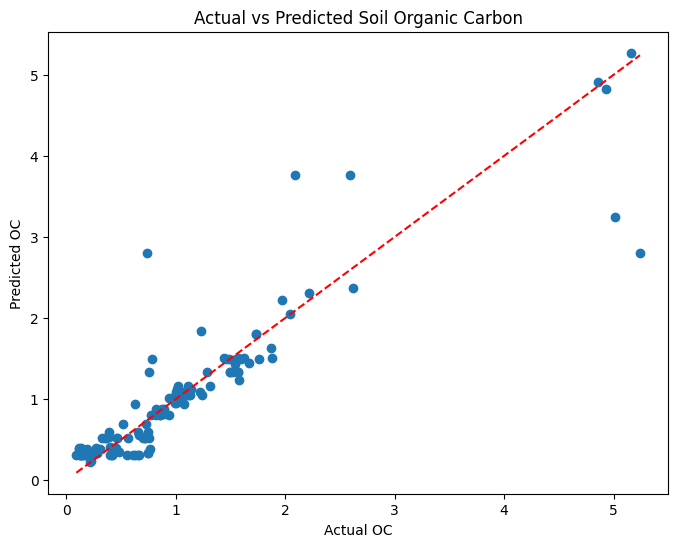

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual OC')
plt.ylabel('Predicted OC')
plt.title('Actual vs Predicted Soil Organic Carbon')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R^2 score: {r2:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")

R^2 score: 0.823
Mean Squared Error (MSE): 0.177
Mean Absolute Error (MAE): 0.218


In [139]:
y_test.mean(), y_pred.mean(), y_test.var(), y_pred.var()

(np.float64(1.078912),
 np.float64(1.1514191397085591),
 np.float64(1.0316649357419356),
 np.float64(1.0879883080082524))

Predictions for Linear Regression

In [155]:
y_pred=pipeline.predict(X_test)

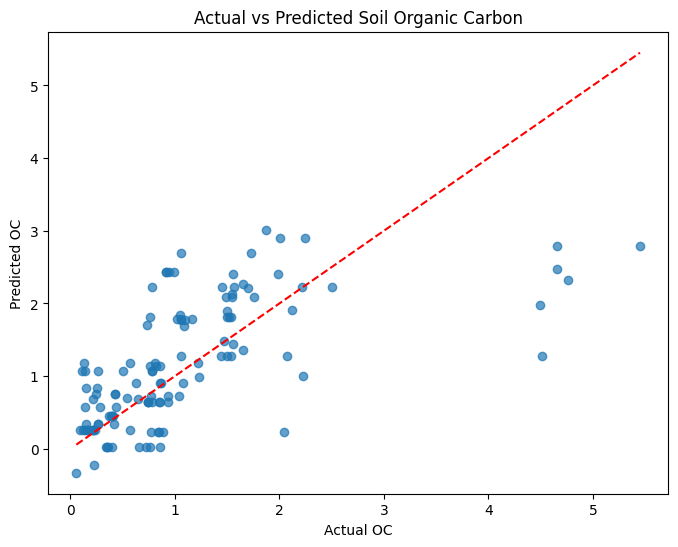

In [156]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual OC')
plt.ylabel('Predicted OC')
plt.title('Actual vs Predicted Soil Organic Carbon')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [157]:
# Calculate R^2 score as a measure of accuracy for regression
accuracy = r2_score(y_test, y_pred)
print(f"R^2 score (accuracy): {accuracy:.3f}")

R^2 score (accuracy): 0.356


Saving model as pkl file

In [15]:
import pickle

# save the soc classification model as a pickle file
model_pkl_file = "soc_classifier_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(pipeline, file)

Using k-folds instead of test/training

In [124]:
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [16]:
# Example new data (replace with your actual data)
new_data = pd.DataFrame({
    'Tannual': [15.0],
    'Pannual': [1000.0],
    'Tillage': ['Reduced'],
    'CoverCropGroup': ['Legume'],
    'GrainCropGroup': ['Monoculture']
})

# Make prediction
predicted_oc = pipeline.predict(new_data)
print(f"Predicted OC: {predicted_oc[0]:.4f}")

Predicted OC: 1.1139
